In [136]:
import scanpy as sc
import squidpy as sq
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Dataset, Data, HeteroData
import torch_sparse
from torch_geometric.loader import NeighborLoader

Dataset with 1 image

In [137]:
#Load dataset 
adata = sq.datasets.imc()

In [138]:
adata.X.shape

(4668, 34)

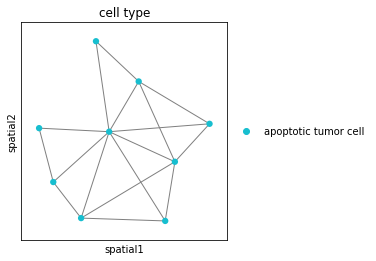

In [139]:
#Sample nodes from training data 
randint=np.random.randint(0,adata.n_obs+1)
sq.gr.spatial_neighbors(adata, coord_type="generic")
_, idx = adata.obsp["spatial_connectivities"][randint, :].nonzero()
idx = np.append(idx, randint)
sc.pl.spatial(
    adata[idx, :],
    color="cell type",
    neighbors_key="spatial_neighbors",
    spot_size=1,
    edges=True,
    edges_width=1,
    img_key=None,
)

In [140]:
#Get adjacency matrix
A=adata.obsp['spatial_connectivities']

In [141]:
#Get edge index
indices=A.nonzero()
edge_index=torch.tensor(np.array(indices))

In [142]:
#Get features of nodes 
X=adata.obs
X=pd.get_dummies(X)
X=X.to_numpy()

In [143]:
X.shape

(4668, 11)

In [144]:
#Get labels of nodes
Y=adata.X
Y.shape

(4668, 34)

In [145]:
Acoo = A.tocoo()

In [146]:
A_sparse = torch.sparse.FloatTensor(torch.LongTensor([Acoo.row.tolist(), Acoo.col.tolist()]),
                              torch.FloatTensor(Acoo.data)).coalesce()

In [151]:
A_sparse

tensor(indices=tensor([[   0,    0,    0,  ..., 4667, 4667, 4667],
                       [  41,   43,   56,  ..., 4566, 4592, 4617]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(4668, 4668), nnz=28008, layout=torch.sparse_coo)

In [158]:
data = Data(x=A_sparse,edge_index=A_sparse.indices(),train_mask=torch.arange(A.shape[0]))

In [159]:
data

Data(x=[4668, 4668], edge_index=[2, 28008], train_mask=[4668])

In [160]:
loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[30] * 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=128,
)


In [161]:
sampled_data = next(iter(loader))

In [162]:
sampled_data ## this is one batch

Data(x=[292, 4668], edge_index=[2, 1254], train_mask=[292], batch_size=128)

Sampled nodes are sorted based on the order in which they were sampled. In particular, the first batch_size nodes represent the set of original mini-batch nodes. Since we gave all the train indices in a sorted fashion the first 128 nodes are sorted the others are their randomly sampled neighbours.

From the documentation on [NeighborLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader):
"More specifically, num_neighbors denotes how much neighbors are sampled for each node in each iteration. NeighborLoader takes in this list of num_neighbors and iteratively samples num_neighbors[i] for each node involved in iteration i - 1."

This means when sampling, after the second iteration, we might resample the nodes we visited, so this is more like a random walk sampling.

In [171]:
sampled_data.train_mask

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 172, 150, 151, 135, 136, 139, 128, 129, 153, 130, 174, 147,
        205, 175, 154, 140, 141, 149, 134, 194, 158, 165, 199, 169, 137, 155,
        157, 152, 166, 143, 144, 145, 173, 142, 156, 177, 162, 164, 193, 186,
        132, 146, 190, 138, 160, 133, 159, 131, 183, 184, 180, 1

In [172]:
for a in loader:
    print(a)

Data(x=[292, 4668], edge_index=[2, 1254], train_mask=[292], batch_size=128)
Data(x=[410, 4668], edge_index=[2, 1734], train_mask=[410], batch_size=128)
Data(x=[438, 4668], edge_index=[2, 1662], train_mask=[438], batch_size=128)
Data(x=[445, 4668], edge_index=[2, 1740], train_mask=[445], batch_size=128)
Data(x=[408, 4668], edge_index=[2, 1584], train_mask=[408], batch_size=128)
Data(x=[438, 4668], edge_index=[2, 1704], train_mask=[438], batch_size=128)
Data(x=[433, 4668], edge_index=[2, 1584], train_mask=[433], batch_size=128)
Data(x=[424, 4668], edge_index=[2, 1662], train_mask=[424], batch_size=128)
Data(x=[413, 4668], edge_index=[2, 1620], train_mask=[413], batch_size=128)
Data(x=[443, 4668], edge_index=[2, 1662], train_mask=[443], batch_size=128)
Data(x=[427, 4668], edge_index=[2, 1638], train_mask=[427], batch_size=128)
Data(x=[431, 4668], edge_index=[2, 1620], train_mask=[431], batch_size=128)
Data(x=[424, 4668], edge_index=[2, 1674], train_mask=[424], batch_size=128)
Data(x=[442,

In [10]:
#Sample n nodes + 1-neighbour and save individual graphs in files (iterate over all nodes)

n=200
no_batches=adata.n_obs//200
for batch in range(no_batches):
    indices=np.random.choice(adata.n_obs, size=200)
    #get features and labels of selected nodes
    X_s=X[indices]
    Y_s=Y[indices]

    #get node indices of direct neighbours (Output: list of length n)
    neigh_ind=[]
    neigh_max=0
    for index in indices:
        neigh_ind.append(A[index].nonzero()[1])
        neigh_max=max(neigh_max,len(A[index].nonzero()[0]))

    #Use neigh_ind to get features of all neighbours of each sampled node (Output array n x neighbours[padded] x features)
    
    #How to do this?
    #Do we want output array: For batch i: no. node samples x neighbours[padded] x features (e.g.200 x max_neighs x no features)
    
    '''X_neigh_all = []
    for index in range(n):
        X_neigh=np.zeros([neigh_max,X.shape[1]])
        for i in 
        for i, neigh in (range(neigh_max),neigh_ind[index]):
            X_neigh[i]=X[neigh]
        X_neigh_all.append(X_neigh)'''


Create Pytorch Geometric dataset

In [11]:
#Create PyG dataset from graphs saved in files
class MyCustomDataset(Dataset):
    def __init__():
        self.filename = .. # List of raw files, in your case point cloud
        super(MyCustomDataset, self).__init()

    @property
    def raw_file_names(self):
        return self.filename
    
    @property
    def processed_file_names(self):
        """ return list of files should be in processed dir, if found - skip processing."""
        processed_filename = []
        return processed_filename
    def download(self):
        pass

    def process(self):
        for file in self.raw_paths:
            self._process_one_step(file)

    def _process_one_step(self, path):
        out_path = (self.processed_dir, "some_unique_filename.pt")
        # read your point cloud here, 
        # convert point cloud to Data object
        data = Data(x=node_features,
                    edge_index=edge_index,
                    edge_attr=edge_attr,
                    y=label #you can add more arguments as you like
                    )
        torch.save(data, out_path)
        return

    def __len__(self):
        return len(self.processed_file_names)

    def __getitem__(self, idx):
        data = torch.load(os.path.join(self.processed_dir, self.processed_file_names[idx]))
        return data

SyntaxError: invalid syntax (3386935298.py, line 4)

In [12]:
#Sample n nodes and save individual graphs in files (iterate over all nodes)
import torch
from torch_geometric.data import Data

x = torch.tensor(X, dtype=torch.float)

data=Data(x=x, edge_index=edge_index)


    



In [13]:
data

Data(x=[4668, 11], edge_index=[2, 28008])

In [72]:
P=np.array([[0,1,1,1],[1,0,1,0],[1,1,0,0],[1,0,0,0]])

In [87]:
indices =[0,1]
neigh_ind=[]
for index in indices:
    neigh_ind.append(P[index].nonzero()[0])

In [88]:
neigh_ind

[array([1, 2, 3]), array([0, 2])]

In [86]:
P[index].nonzero()[0]

array([0, 2])